# Add County data to EJScreen dataset

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import Data

In [2]:
df = pd.read_csv('../data/epa_data/EJSCREEN_data_all_years.csv')
annual_energy_cost = pd.read_csv('../data/epa_data/lead_tool_map_data_annual_energy_cost.csv')

## Merge Data

In [3]:
df.shape, len(df['ID'].unique()) # Each ID is unique.

((23212, 376), 23212)

In [4]:
df['SHORT_ID'] = df['ID'] // 10
df = df.reindex((list(df.columns)[:1] + list(df.columns)[-1:] + list(df.columns)[1:-1]), axis = 1)

In [5]:
annual_energy_cost.shape, len(df['SHORT_ID'].unique())

((7980, 5), 8057)

Not every location is included in the annual energy cost data set.

### Understanding the missing geographic locations

In [6]:
annual_energy_cost.shape[0], len(annual_energy_cost['Geography ID'].unique()) # Each Geography ID is unique.

(7980, 7980)

In [7]:
len(df['SHORT_ID'].unique()) - annual_energy_cost.shape[0]

77

There are 77 locations not included.

In [8]:
mask = [] # A mask for the codes missing from the energy data set
for i in annual_energy_cost['Geography ID']:
    if i in df['SHORT_ID'].values:
        mask.append(False)
    else:
        mask.append(True)
        
sum(mask)

0

There are no locations in the energy cost dataset not represented here.

In [9]:
mask = [] # A mask for the codes missing from the energy data set
for i in df['SHORT_ID']:
    if i in annual_energy_cost['Geography ID'].values:
        mask.append(False)
    else:
        mask.append(True)
        
sum(mask)

79

The mask has length 79 because `df['SHORT_ID']` has duplicates.

In [10]:
df[mask]['SHORT_ID'][df[mask]['SHORT_ID'].duplicated()]

10698    6053014104
10699    6053014104
Name: SHORT_ID, dtype: int64

In [11]:
df[df['SHORT_ID'] == 6053014104]

,ID,SHORT_ID,STATE_NAME,ST_ABBREV,REGION,ACSTOTPOP_2021,CANCER_2021,P_CANCR_2021,D_CANCR_2_2021,P_CANCR_D2_2021,...,RESP_2016,P_RESP_2016,D_RESP_2_2016,P_RESP_D2_2016,UNDER5PCT_2016,P_UNDR5PCT_2016,VULEOPCT_2016,P_VULEOPCT_2016,Shape_Area_2016,Shape_Length_2016
10697,60530141041,6053014104,California,CA,9,1892,20.0,16.0,-1659.564895,27.0,...,0.597559,3.346675,-159.010872,44.601699,0.0,3.906772,0.19621,29.636455,4.436916e+06,11379.855206
10698,60530141042,6053014104,California,CA,9,0,20.0,16.0,-0.000000,33.0,...,0.597559,3.346675,-0.000000,58.765310,0.0,3.906772,0.00000,0.010863,2.317585e+05,2280.707759
10699,60530141043,6053014104,California,CA,9,0,20.0,16.0,-0.000000,33.0,...,0.597559,3.346675,-0.000000,58.765310,0.0,3.906772,0.00000,0.010863,3.196255e+05,4488.647001


This is the tract within the city of Seaside that includes California State University - Monterey Bay. This is detailed [here](https://www.citivelocity.com/citybuilder/eppublic/cb/us/cities/15465/tracts/6053014104).

In [12]:
df[mask]['ACSTOTPOP_2021'].sum()

100533

The combined population of the places not represented in the annual energy dataset is about one hundred thousand.

In [13]:
df[mask]['ID'].unique()

array([60019900000, 60139900000, 60159900000, 60179900000, 60190079011,
       60239901000, 60290043021, 60290046011, 60290046031, 60290060021,
       60310016021, 60319818001, 60372653011, 60373200001, 60374024041,
       60374032001, 60375516001, 60375746011, 60375747001, 60379010031,
       60379202001, 60379800011, 60379800021, 60379800031, 60379800041,
       60379800051, 60379800061, 60379800071, 60379800091, 60379800131,
       60379800181, 60379800201, 60379800221, 60379800231, 60379800251,
       60379800281, 60379800301, 60379901000, 60379902000, 60379903000,
       60411220001, 60419901000, 60459901000, 60530141041, 60530141042,
       60530141043, 60539800001, 60539900000, 60599800001, 60599901000,
       60619900000, 60659800041, 60659810001, 60710123001, 60719801001,
       60719802001, 60730038001, 60730055001, 60730062001, 60730063001,
       60730099021, 60739901000, 60759804011, 60759901000, 60790114001,
       60799900000, 60819843001, 60819901000, 60839800001, 60839

In [14]:
df[mask][df[mask]['ACSTOTPOP_2021'] != 0].shape

(32, 377)

City builder is a [website](https://www.citivelocity.com/citybuilder/eppublic/cb/) that contains descriptions of the census tracts described by the shortcodes.
Using that services I found that many of the places not included in the annual energy cost data set were over water, military bases, parkland, or major office parks like universal studios.
Still, some small towns are included in this mask (there appear to be 32).

## Consider missing values

I will show that removing the places not included in this annual energy cost data set removes many of the missing values.

In [15]:
mask = [] # A mask for the codes not missing from the energy data set
for i in df['SHORT_ID']:
    if i in annual_energy_cost['Geography ID'].values:
        mask.append(True)
    else:
        mask.append(False)
        
sum(mask)

23133

In [16]:
df[mask].isnull().sum().unique()

array([    0,   322, 12452,     2,   392, 12110,  2687], dtype=int64)

In [17]:
print('The number of columns with missing data with the mask applied: {}\
      \nThe number of columns with missing data on the full dataset: {}'
          .format(sum([1 if i != 0 else 0 for i in list(df[mask].isnull().sum().values)]), 
                  sum([1 if i != 0 else 0 for i in list(df.isnull().sum().values)])))

The number of columns with missing data with the mask applied: 44      
The number of columns with missing data on the full dataset: 140


In [18]:
sum(df[mask]['ACSTOTPOP_2021'] == 0), sum(df['ACSTOTPOP_2021'] == 0)

(25, 72)

### Merge Data

In [19]:
columns_to_types = ['ACSTOTPOP',
'CANCER',
'DSLPM',
'P_LDPNT',
'LESSHSPCT',
'LINGISOPCT',
'LOWINCPCT',
'MINORPCT',
'OVER64PCT',
'OZONE',
'PM25',
'PNPL',
'PRE1960PCT',
'PRMP',
'PTRAF',
'PTSDF',
'PWDIS',
'RESP',
'UNDER5PCT',
'VULEOPCT']

years = ['_2021', '_2020', '_2019', '_2018', '_2017', '_2016']

columns_to_keep = []
for cols in columns_to_types:
    for year in years:
        columns_to_keep.append(cols + year)
        
len(columns_to_keep)

120

In [20]:
smaller_df = df.loc[:, ['ID', 'SHORT_ID', 'STATE_NAME', 'ST_ABBREV', 'REGION'] + ['OBJECTID_2021', 'Shape_Area_2021', 'Shape_Length_2021'] + columns_to_keep]
smaller_df.rename(columns={'OBJECTID_2021': 'OBJECTID', 'Shape_Area_2021': 'Shape_Area', 'Shape_Length_2021': 'Shape_Length'}, inplace = True)

In [21]:
merged_df = annual_energy_cost.merge(smaller_df, right_on='SHORT_ID', left_on = 'Geography ID')

In [22]:
merged_df.head(2)

,Geography ID,Name,County,Tribal Areas,Avg. Annual Energy Cost,ID,SHORT_ID,STATE_NAME,ST_ABBREV,REGION,...,UNDER5PCT_2019,UNDER5PCT_2018,UNDER5PCT_2017,UNDER5PCT_2016,VULEOPCT_2021,VULEOPCT_2020,VULEOPCT_2019,VULEOPCT_2018,VULEOPCT_2017,VULEOPCT_2016
0,6099000101,Census Tract 1.01,Stanislaus County,NaN,3388,60990001011,6099000101,California,CA,9,...,0.037568,0.035411,0.053857,0.057455,0.198377,0.173641,0.154118,0.165859,0.157010,0.090483
1,6099000101,Census Tract 1.01,Stanislaus County,NaN,3388,60990001012,6099000101,California,CA,9,...,0.024457,0.037946,0.042279,0.031906,0.246747,0.255277,0.281929,0.271205,0.319853,0.268262


In [25]:
def comparision_by_county(predictor = 'LOWINCPCT', predictor_labels = ['Least Poverty', 'Less Poverty', 'More Poverty', 'Most Poverty'], 
                         target = 'Avg. Annual Energy Cost', target_label = 'Average Annual Energy Cost', line_height = 2_000, top = 5500):
    # Find the Quartiles
    quantiles_all_years = []
    for u in ['_2021', '_2020', '_2019', '_2018', '_2017', '_2016']:
        quantiles = []
        for v in [0.25, 0.5, 0.75]:
            quantiles.append(merged_df.groupby('County').mean()[predictor + u].quantile(v))

        quantiles_all_years.append(quantiles)

    # Create masks
    masks_all_years = []
    for year, quantiles in zip(['_2021', '_2020', '_2019', '_2018', '_2017', '_2016'], quantiles_all_years):
        mask = []
        mask.append(merged_df.groupby('County').mean()[predictor + year] < quantiles[0])
        mask.append((merged_df.groupby('County').mean()[predictor + year] >= quantiles[0]) & (merged_df.groupby('County').mean()[predictor + year] < quantiles[1]))
        mask.append((merged_df.groupby('County').mean()[predictor + year] >= quantiles[1]) & (merged_df.groupby('County').mean()[predictor + year] < quantiles[2]))
        mask.append(merged_df.groupby('County').mean()[predictor + year] >= quantiles[2])
        masks_all_years.append(mask)
    
    # Make Plots
    fig, ax = plt.subplots(ncols = 4, nrows = 6, figsize = (16, 24), tight_layout = True)
    
    if target == 'Avg. Annual Energy Cost':
        for year, masks, col, color in zip(['_2021', '_2020', '_2019', '_2018', '_2017', '_2016'], masks_all_years, [0, 1, 2, 3, 4, 5], ['tab:cyan', 'tab:green', 'tab:purple', 'tab:red', 'tab:blue', 'tab:orange']):
            for row, title in zip([0, 1, 2, 3], predictor_labels):
                ax[col][row].bar(x = merged_df.groupby('County').mean()[masks[row]][target].index, 
                                 height = merged_df.groupby('County').mean()[masks[row]][target].values,
                                 color = color)
                ax[col][row].axhline(2000, color='black')
                ax[col][row].set_ylim(0, 5500)
                ax[col][row].set_ylabel(target_label)
                ax[col][row].set_title(title + ' in ' + year[1:] )
                plt.setp(ax[col][row].xaxis.get_majorticklabels(), rotation=90)
    else:
        for year, masks, col, color in zip(['_2021', '_2020', '_2019', '_2018', '_2017', '_2016'], masks_all_years, [0, 1, 2, 3, 4, 5], ['tab:cyan', 'tab:green', 'tab:purple', 'tab:red', 'tab:blue', 'tab:orange']):
            for row, title in zip([0, 1, 2, 3], predictor_labels):
                ax[col][row].bar(x = merged_df.groupby('County').mean()[masks[row]][target + year].index, 
                                 height = merged_df.groupby('County').mean()[masks[row]][target + year].values,
                                 color = color)
                ax[col][row].axhline(line_height, color='black')
                ax[col][row].set_ylim(0, top)
                ax[col][row].set_ylabel(target_label + year[1:])
                ax[col][row].set_title(title + ' in ' + year[1:] )
                plt.setp(ax[col][row].xaxis.get_majorticklabels(), rotation=90)
                
    plt.savefig('../data/figures/'+'comparision_by_county_'+predictor+'_'+target+'.png')

### Data visualizations

I believe these graphs show that higher energy costs are more associated with less positive outcomes with respect to poverty and various environmental factors.

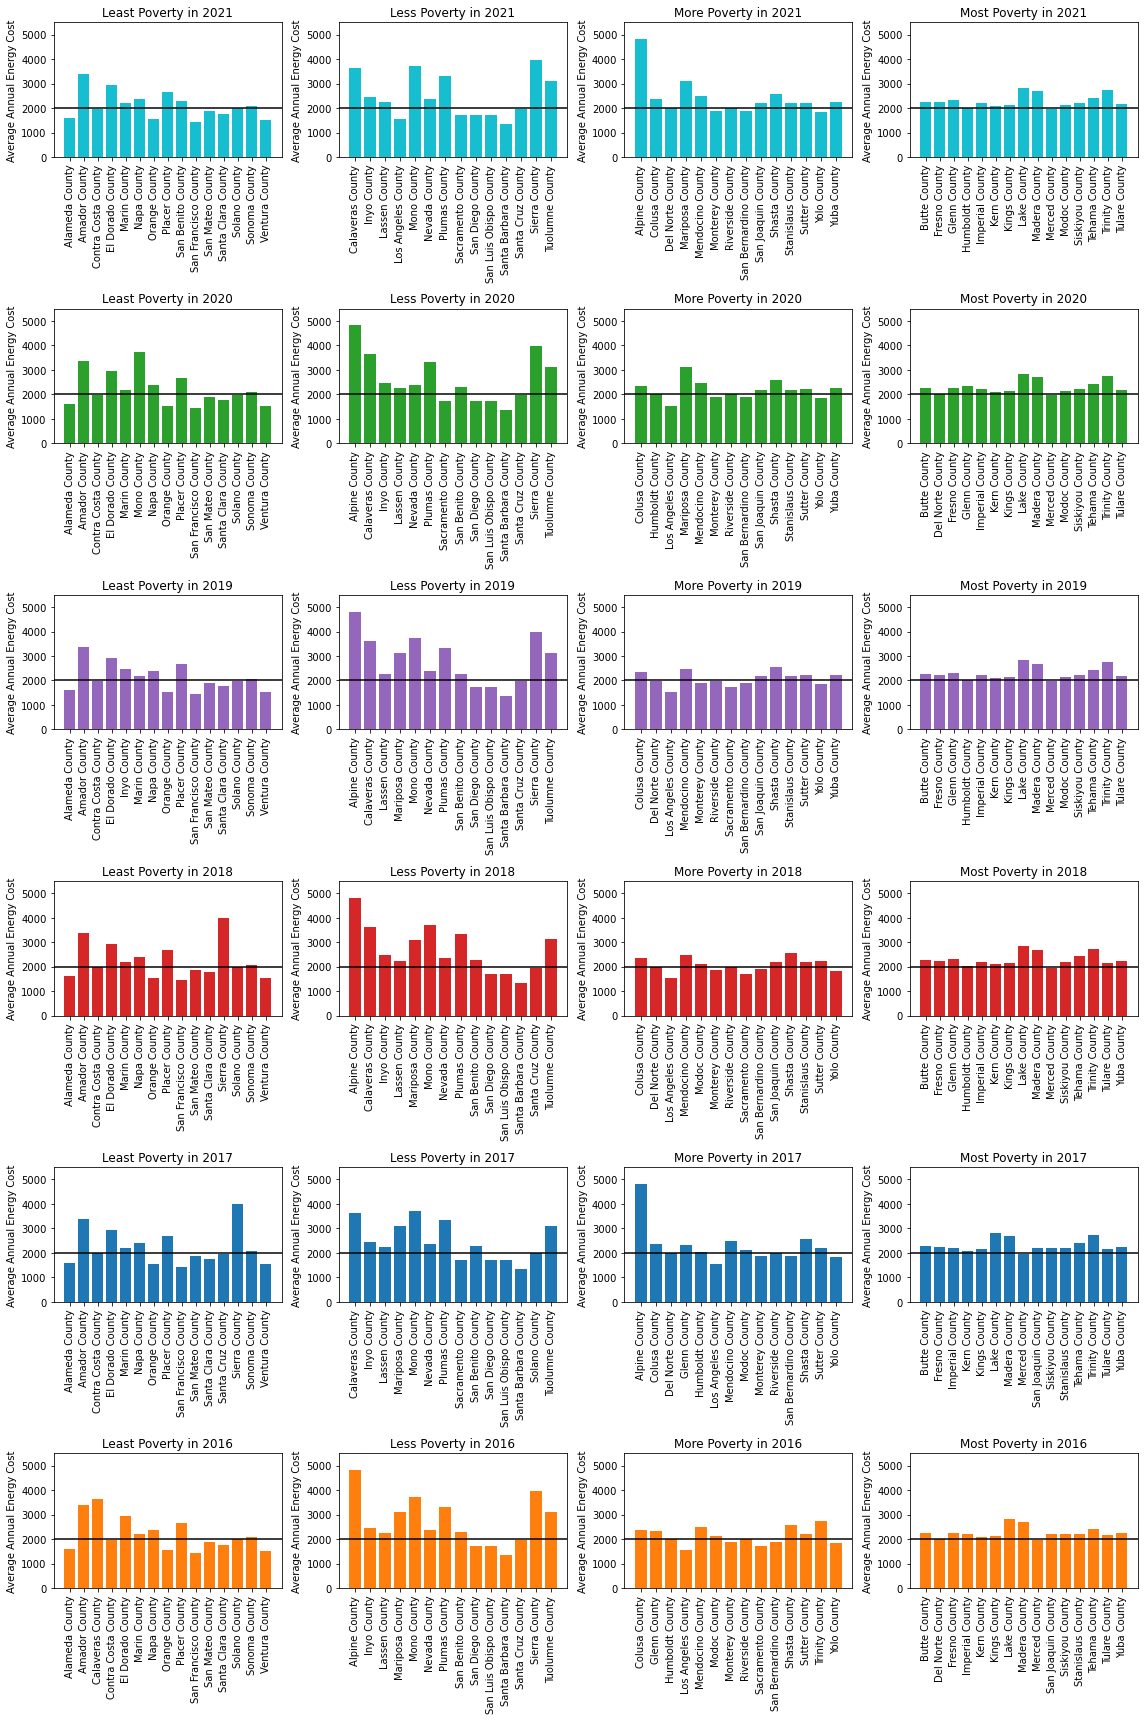

In [26]:
comparision_by_county()

Low income counties tend to be very consistently priced. Still, while there is more variation, the counties that are wealthier are more liekly to have cheaper energy. This trend seems to be increasing through the years. This may be related to higher income counties being more able to switch to green energy which is increases competition and brings down the price. This ____

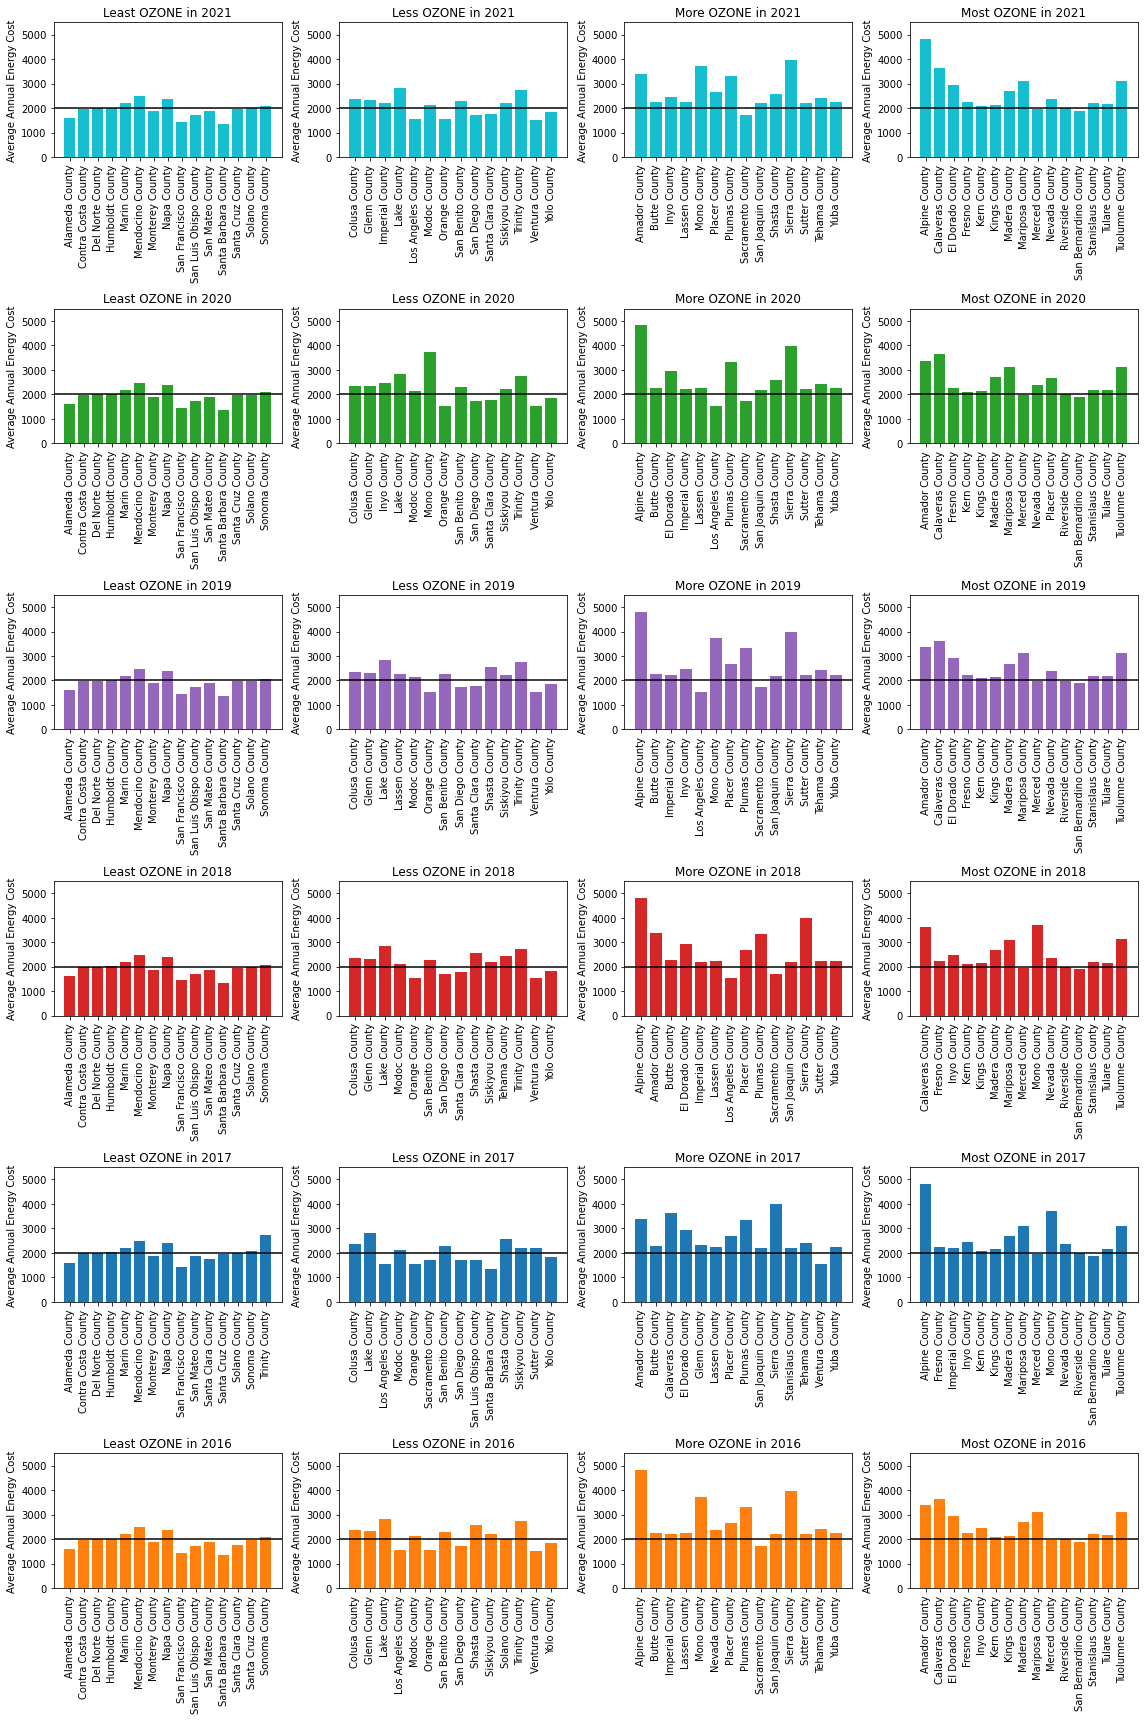

In [27]:
comparision_by_county(predictor = 'OZONE', predictor_labels = ['Least OZONE', 'Less OZONE', 'More OZONE', 'Most OZONE'])

This graph shows as well that more ozone polution in the lower atmosphere is related to higher energy costs.

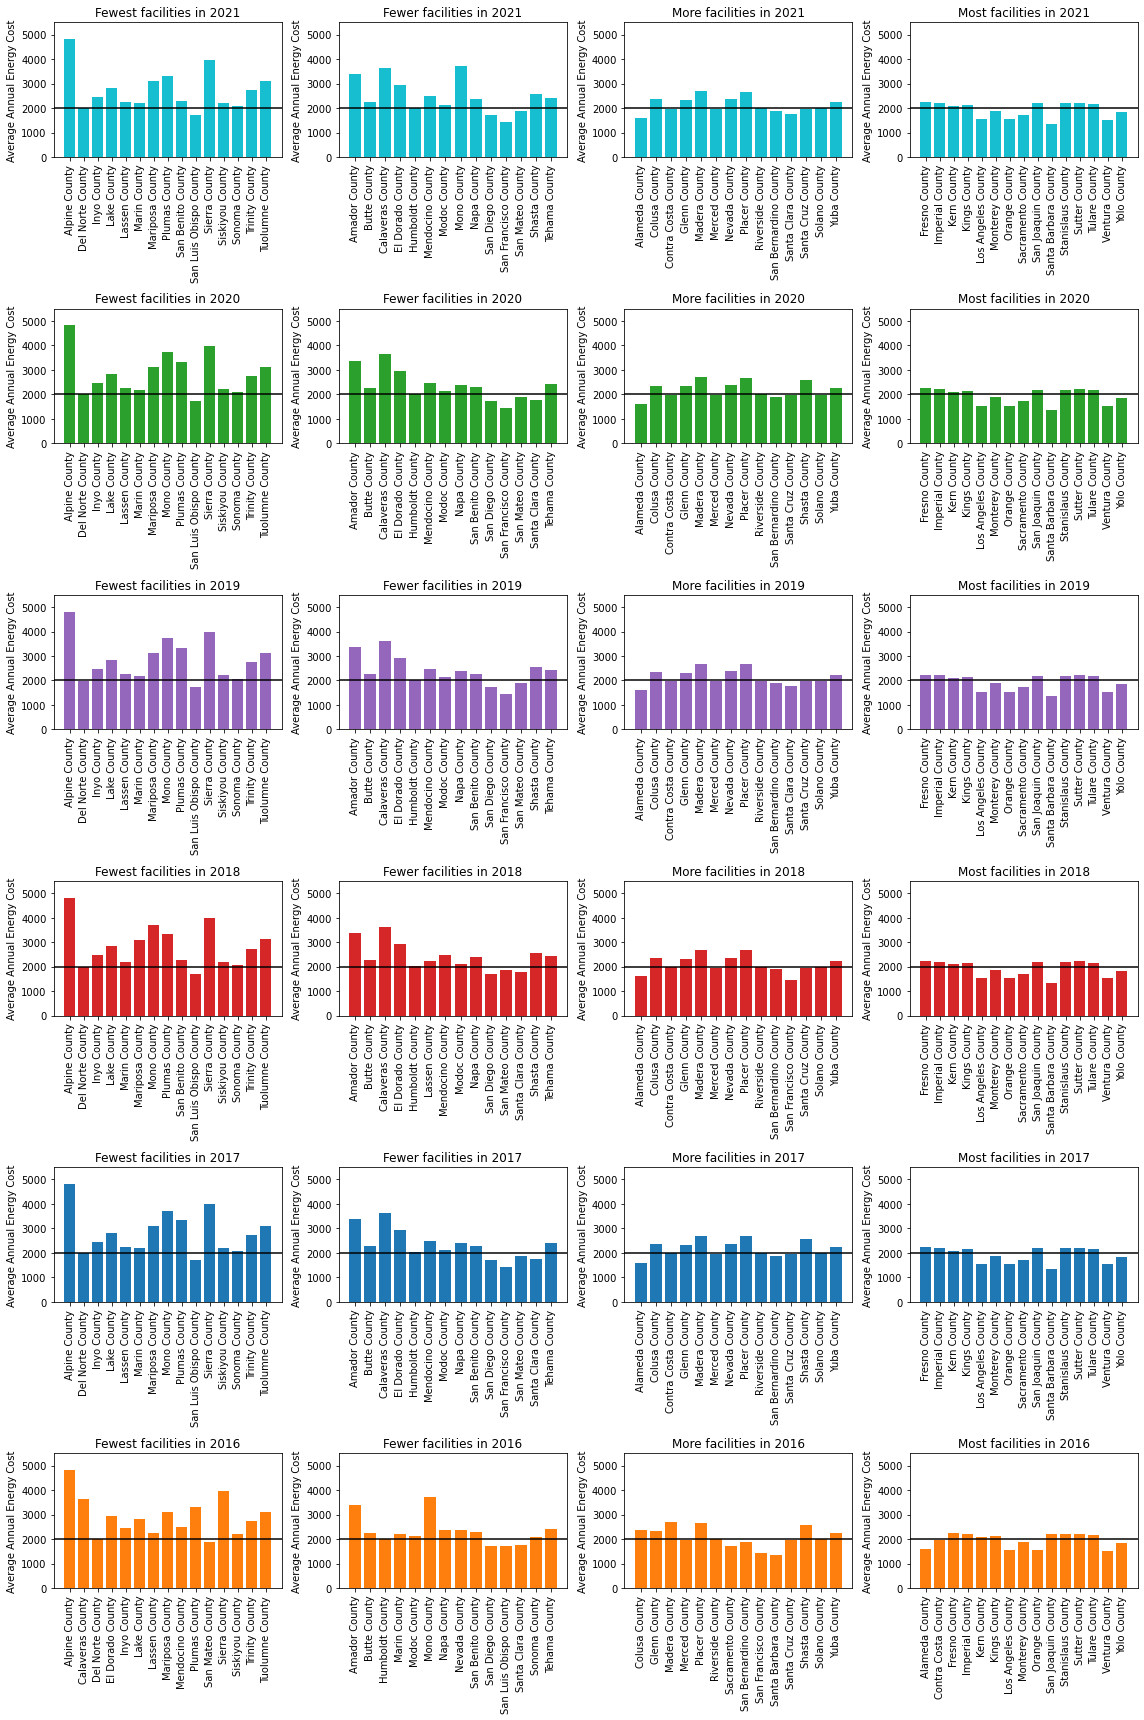

In [28]:
comparision_by_county(predictor = 'PRMP', predictor_labels = ['Fewest facilities', 'Fewer facilities', 'More facilities', 'Most facilities'])

This is graph consider the proximity of facitities that are required to participate in the risk management program. These facilities likely are looking to reduce their energy costs and so this distribution makes sense.

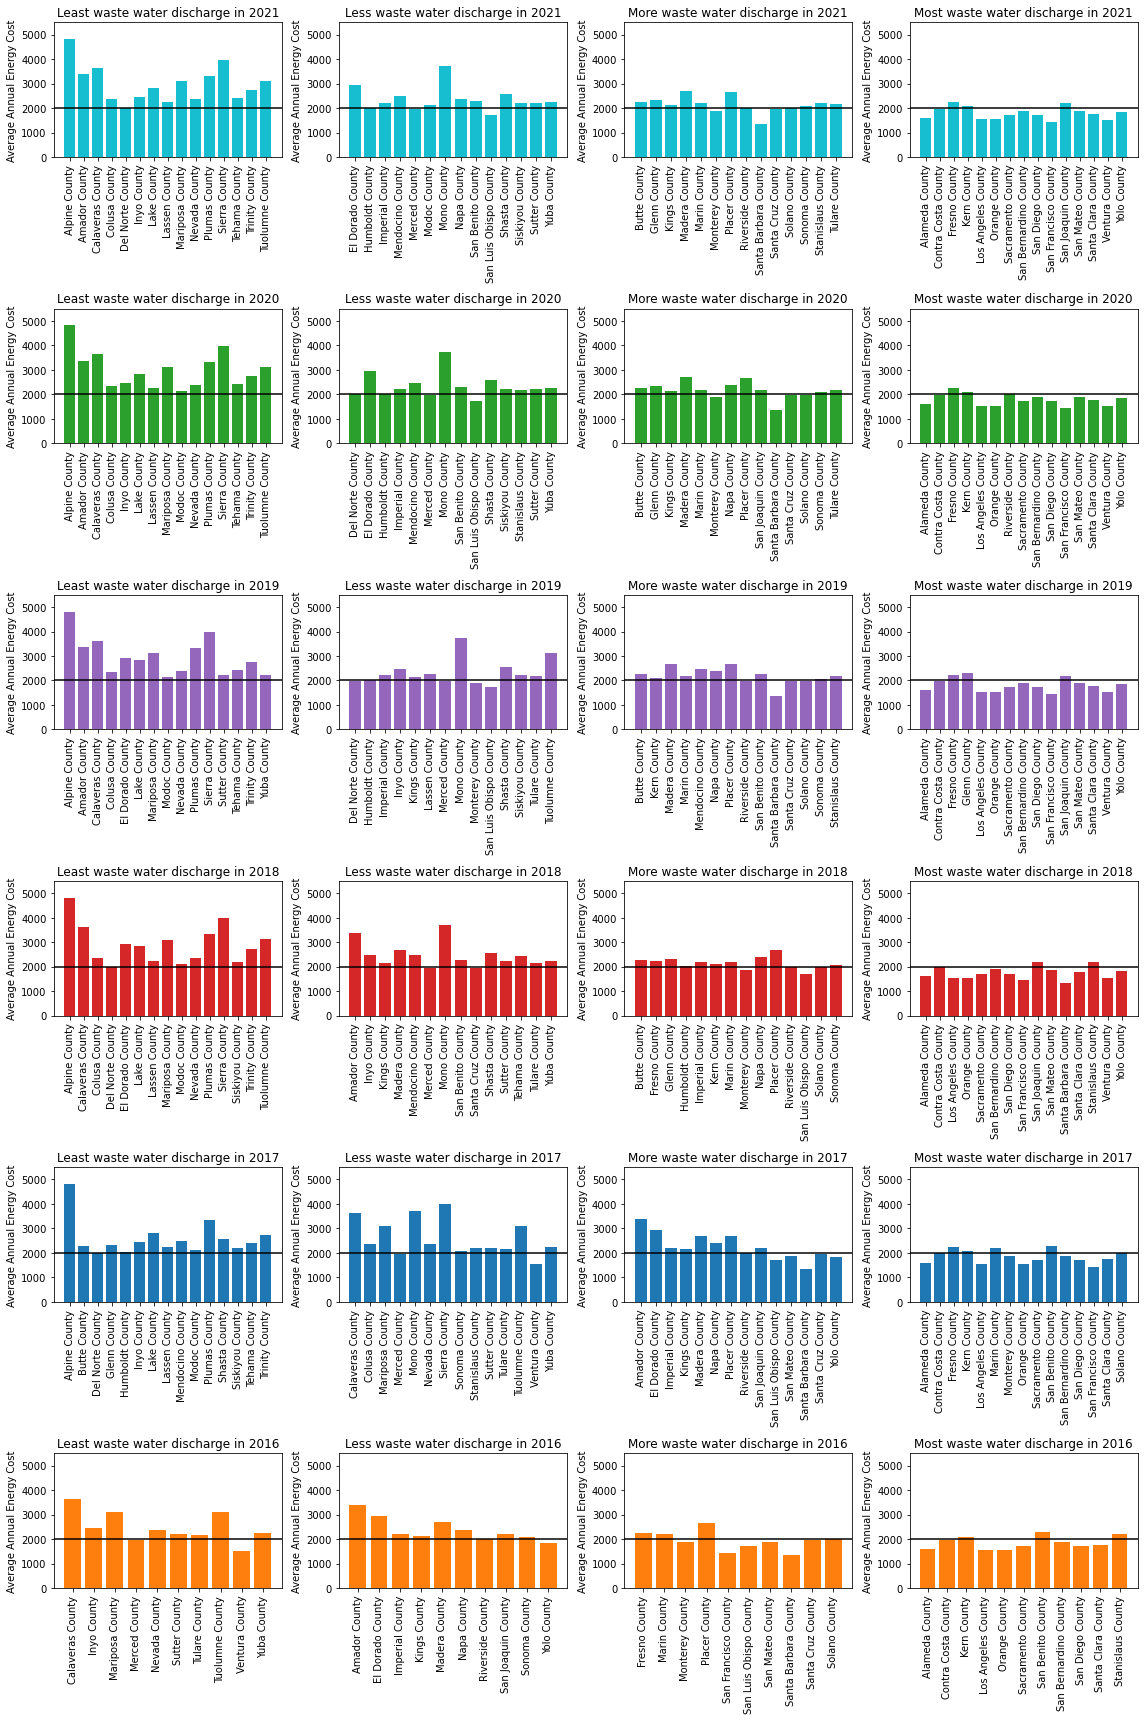

In [29]:
comparision_by_county(predictor = 'PTSDF', predictor_labels = ['Least waste water discharge', 'Less waste water discharge', 'More waste water discharge', 'Most waste water discharge'])

This graph compares the amount of waste water discharge to energy cost. Cities are much more prone to have cheaper energy costs and are also will have much higher rates of waste water discharge. So in this graph counties with major cities get sorted into the upper quartile category and so the costs are lower for that category.

Fundamentally this data shows that there are injustices related to energy pricing. However, there are many confounding variables when looking at data like this. This includes population, the extent the location is rural, and how low income communities are geographically distributed. I would like to perform more work to untangle these variables. This future work may include finding more data to link these data to where energy is produced and the local energy mix consumed.